In [15]:
import pandas as pd
import bamboolib as bam
import plotly.express as px
import numpy as np
from datetime import datetime
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn
bam.enable()
url1 = "https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx"
url2 = "https://dshs.texas.gov/coronavirus/TexasCOVID-19CumulativeTestsOverTimebyCounty.xlsx"
path1 = "./Rt_no_Rolling.csv"
def getExcel(url, sheet, head):
    df = pd.read_excel(url,sheet_name=sheet, header=head)
    df=df.truncate(before=0,after=253)
    return df

df = getExcel(url1, 'Cases by County', 2)
df.keys()
df2 = df.set_index('County Name')

dftesting  = getExcel(url2, 'Total Tests Received', 1)
dftesting.keys()
dft2 = dftesting.set_index('County')

dfrate = pd.read_csv(path1)
dfr2 = dfrate.truncate(47, 191)

dfr2=dfr2.rename(columns={'Unnamed: 0': 'Dates'})
dfr2=dfr2.set_index('Dates')

dfr2=dfr2.T.copy()
dates = [datetime.strptime(sub, '%Y/%m/%d') for sub in dfr2.keys()]
dfr2=dfr2.T.copy()
dfr2.index = dates
dfr2.T.mean()

Success: the bamboolib extension was enabled successfully. You can disable it via 'bam.disable()'. You will now see a magic bamboolib button when you display your dataframes, for example via 'df'


2020-04-21    2.148312
2020-04-22    2.286394
2020-04-23    2.259013
2020-04-24    2.389237
2020-04-25    2.527050
                ...   
2020-09-08    1.895782
2020-09-09    1.891332
2020-09-10    1.711340
2020-09-11    1.561637
2020-09-12    1.937014
Length: 145, dtype: float64

In [16]:
url3 = 'https://www.indexmundi.com/facts/united-states/quick-facts/texas/population#table'
population = pd.read_html(url3)
pop = population[0]
pop = pop.loc[~(pop['County'].isin(['King', 'Borden', 'Loving']))]
pop

,County,Value
0,Anderson,58057
1,Andrews,18128
2,Angelina,87092
3,Aransas,23792
4,Archer,8786
...,...,...
249,Wood,45129
250,Yoakum,8591
251,Young,18045
252,Zapata,14190


In [17]:
#data prep
dft3 = dft2.T.copy()
dft3 = dft3.reset_index()
dft3 = dft3.replace('--', np.nan)
dft3 = dft3.replace('-', np.nan)
dft3 = dft3.fillna(method='ffill')
dft3.columns = [str(column) for column in dft3.columns]
dft3 = dft3.drop(columns=['Borden', 'King', 'Loving'])
dft3.index = dft3['index']
dft3 = dft3.drop(columns='index')
dft3 = dft3.T.copy()
pattern = re.compile('[a-z]+\s[0-9]+', re.IGNORECASE)
#get dates
dates2 = [datetime.strptime(pattern.findall(sub)[0], '%B %d') for sub in dft3.keys()]
dates2
dft3 = dft3.T.copy()
dft3.index = dates2

#get early testing data
dft3e = dft3.truncate('1900-04-21', '1900-06-30')
dft3em = dft3e.mean().to_frame()
dft3em.index.name = 'County'
dft3em = pd.merge(pop, dft3em, on='County')
dft3em.columns = ['County', 'Population', 'Mean_Tests']
dft3em['Per_100k'] = (dft3em['Mean_Tests'] / dft3em['Population']) * 100000
dft3em

,County,Population,Mean_Tests,Per_100k
0,Anderson,58057,1783.239437,3071.532178
1,Andrews,18128,41.014085,226.247156
2,Angelina,87092,2015.140845,2313.807060
3,Aransas,23792,193.633803,813.860974
4,Archer,8786,50.253521,571.972697
...,...,...,...,...
246,Wood,45129,430.647887,954.259761
247,Yoakum,8591,101.521127,1181.714897
248,Young,18045,492.887324,2731.434325
249,Zapata,14190,203.352113,1433.066333


In [18]:
#get a threshold
mean_of_all = dft3em['Per_100k'].T.copy().mean()
stdv = dft3em['Per_100k'].T.copy().std()
stdv

1265.0072772189797

In [48]:

#get the mean of each counties testing
dft3eg = []
dft3el = []
#if a counties mean testing is greater than the average mean append
for i in dft3em.itertuples(): 
    if float(i[4]) > mean_of_all + stdv:
        dft3eg.append(i)
    if float(i[4]) < mean_of_all - stdv:
        dft3el.append(i)

#put the list into a dataframe
dft4eg = pd.DataFrame(dft3eg)
dft4el = pd.DataFrame(dft3el)

#get a list of all counties with above average testing
dft3g = dft3e[dft4eg['County']]
dft3l = dft3e[dft4el['County']]
dfearly = dft3g
dfearly2 = dft3l
dfearly = dfearly.reset_index()
dfearly = dfearly.drop(columns=['index'])
dfearly2 = dfearly2.reset_index()
dfearly2 = dfearly2.drop(columns=['index'])
dfearly

County,Armstrong,Blanco,Bowie,Coryell,Dallas,Donley,Foard,Fort Bend,Galveston,Hamilton,...,La Salle,Lampasas,Mason,Moore,Oldham,Potter,Shelby,Titus,Walker,Washington
0,4.0,144.0,910.0,299.0,18374.0,11.0,0.0,5745.0,1547.0,96.0,...,13.0,93.0,1.0,64.0,6.0,1361.0,191.0,33.0,673.0,105.0
1,5.0,147.0,999.0,322.0,19297.0,11.0,0.0,6127.0,1609.0,100.0,...,13.0,96.0,1.0,92.0,6.0,1489.0,202.0,39.0,743.0,111.0
2,8.0,284.0,981.0,254.0,19476.0,20.0,1.0,6455.0,1663.0,25.0,...,19.0,100.0,2.0,106.0,7.0,1340.0,249.0,21.0,404.0,83.0
3,8.0,337.0,1133.0,378.0,22168.0,20.0,1.0,15375.0,1764.0,110.0,...,20.0,116.0,4.0,110.0,8.0,1589.0,296.0,34.0,637.0,122.0
4,8.0,366.0,1218.0,402.0,23587.0,22.0,1.0,16425.0,1842.0,114.0,...,21.0,132.0,4.0,128.0,8.0,1644.0,318.0,38.0,662.0,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,180.0,2251.0,7114.0,7092.0,160408.0,195.0,96.0,95513.0,40739.0,820.0,...,544.0,1583.0,365.0,2922.0,116.0,14983.0,1543.0,2964.0,13509.0,2540.0
67,180.0,2319.0,7333.0,7108.0,166110.0,197.0,96.0,98749.0,42776.0,823.0,...,550.0,1588.0,366.0,2931.0,119.0,15072.0,1558.0,2970.0,13633.0,2556.0
68,181.0,2337.0,7803.0,7235.0,177725.0,197.0,96.0,100796.0,45206.0,831.0,...,552.0,1603.0,367.0,3136.0,122.0,15515.0,1582.0,2982.0,13757.0,2567.0
69,184.0,2365.0,7831.0,7274.0,181157.0,197.0,96.0,103070.0,46692.0,837.0,...,559.0,1635.0,371.0,3138.0,122.0,15597.0,1599.0,2987.0,13826.0,2579.0


In [39]:
dfr2 = dfr2.fillna(0.0)
dfre = dfr2.truncate('2020-07-01', '2020-09-09')
dfre = dfre.reset_index()
dfre = dfre.drop(columns=['index'])
dfre

,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
0,2.645781,1.163854,1.013150,1.490662,1.019603,4.954606,1.897683,1.184034,0.911764,3.689861,...,1.768367,1.030384,2.214843,1.262299,1.544588,1.707694,2.019239,2.174833,1.189885,1.130291
1,2.290951,0.926648,1.026659,1.310078,1.032529,4.985389,1.676411,0.889900,0.831145,2.642330,...,1.816185,0.886956,1.952372,1.124305,1.581389,1.596854,1.909006,2.049486,1.034556,1.156370
2,1.730377,0.891797,1.026416,1.478520,1.029700,4.995478,1.530534,1.427799,0.786353,2.004895,...,1.422522,0.640292,1.678523,0.941834,1.488334,1.386229,1.769690,1.691432,1.135753,1.188719
3,1.635556,0.832551,1.767313,1.264151,1.431913,4.998643,1.242476,1.740767,1.221993,1.576078,...,1.288399,1.508523,1.408022,1.132026,1.311818,1.724982,1.353999,1.174929,1.275982,1.536821
4,2.070569,1.153290,1.352635,1.259657,1.933382,4.999603,1.145664,1.937640,0.891206,0.767467,...,1.124487,1.378361,1.188755,1.002780,1.296091,1.480613,1.226059,1.308988,0.968253,1.512071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,3.177342,1.021463,0.038184,1.568059,0.741262,4.121909,0.613292,1.039735,0.878142,0.649514,...,1.535702,0.476266,1.154687,0.630973,0.318868,0.676193,1.197334,0.593863,0.555830,1.053035
67,3.861652,0.655903,1.760863,1.167205,1.010433,4.632147,1.379256,1.008049,1.154439,1.123426,...,1.205433,0.851558,1.835815,1.349446,0.464588,0.978420,0.789022,0.918924,1.504519,2.009379
68,3.813838,0.771418,2.461149,1.052067,0.835263,4.864684,2.226263,1.323308,1.395559,3.920929,...,1.001839,0.923694,3.115081,1.646460,0.759696,1.781072,0.424266,1.097313,1.648694,2.059824
69,2.458415,0.676085,5.556528,0.082536,0.980844,9.908210,3.133568,0.903057,0.773499,12.202994,...,0.127312,0.988381,3.081494,1.377600,0.858090,1.693617,0.813481,1.187160,1.695661,2.151479


In [41]:
dfreg = dfre[dft4eg['County']]
dfrel = dfre[dft4el['County']]
dfrel

,Andrews,Archer,Cochran,Coke,Dallam,Dickens,Fisher,Garza,Hockley,Howard,...,Kent,Kinney,Rains,Roberts,Scurry,Stonewall,Terrell,Upshur,Winkler,Zavala
0,1.163854,1.019603,5.000000,1.549307,0.338484,4.999887,1.833315,0.204997,3.179288,1.229482,...,0.000000,1.455015,2.362309,4.630928,6.219790,0.000000,2.030493,2.682257,1.262299,1.130291
1,0.926648,1.032529,5.000000,2.327189,0.407326,4.999968,1.703163,0.246137,2.266164,1.218290,...,0.000000,2.245439,1.955162,5.436085,4.327075,0.000000,1.710578,2.298949,1.124305,1.156370
2,0.891797,1.029700,5.000000,3.297533,0.479083,4.999991,1.343629,0.343446,1.729598,1.202648,...,0.000000,3.238874,1.609040,3.846902,2.892387,0.000000,1.522793,1.851169,0.941834,1.188719
3,0.832551,1.431913,15.000000,4.134982,1.286874,4.999998,1.197957,1.631390,2.076320,1.806669,...,0.000000,4.103890,1.026730,3.898019,2.730093,0.000000,0.953892,1.417504,1.132026,1.536821
4,1.153290,1.933382,19.573529,4.637201,1.595152,4.999999,1.158042,6.586213,1.714463,2.260297,...,0.000000,4.624632,0.941874,4.090855,1.816834,0.000000,0.463830,1.071002,1.002780,1.512071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,1.021463,0.741262,2.003006,0.796091,0.827049,0.538221,0.305668,2.317322,0.797323,2.181336,...,4.114769,2.061218,0.573685,3.525128,1.073131,1.264967,4.999603,0.874527,0.630973,1.053035
67,0.655903,1.010433,1.527124,1.033821,1.087479,0.385108,0.616308,3.291180,0.645676,1.554517,...,4.629332,1.823580,0.696554,4.323492,0.951706,2.052603,4.999887,1.391595,1.349446,2.009379
68,0.771418,0.835263,1.530267,3.021198,0.920256,0.157231,0.854451,4.131892,0.773739,1.195535,...,4.863745,0.863438,0.813001,4.739648,1.060878,3.082647,4.999968,2.182496,1.646460,2.059824
69,0.676085,0.980844,1.419957,4.572509,1.961083,0.180865,1.152336,4.636035,0.777839,1.505558,...,4.953818,1.691798,1.045041,9.820056,1.178835,4.013416,4.999991,3.065265,1.377600,2.151479


In [52]:
#mean infection rate above average 1 std
X = dfreg.T.mean()
Y = dfearly.T.mean()
#mean infection rate below average 1 std
X2 = dfearly2.T.mean()
Y2 = dfrel.T.mean()

data3 = pd.concat([X,Y], axis=1)
data3.columns = ['Infection_Rate', 'Mean_Tests']
data4 = pd.concat([X2,Y2], axis=1)
data4.columns = ['Infection_Rate', 'Mean_Tests']
#data3.index = keys2
data4

,Infection_Rate,Mean_Tests
0,6.652174,1.937455
1,7.260870,1.843043
2,7.173913,1.713139
3,10.260870,2.285589
4,10.652174,2.738303
...,...,...
66,82.434783,1.652873
67,84.695652,1.814845
68,88.260870,2.034562
69,90.000000,2.514489


In [53]:
model1 = smf.ols('Mean_Tests~Infection_Rate',data = data3)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Mean_Tests   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     5.912
Date:                Tue, 29 Sep 2020   Prob (F-statistic):             0.0176
Time:                        18:47:31   Log-Likelihood:                -732.80
No. Observations:                  71   AIC:                             1470.
Df Residuals:                      69   BIC:                             1474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.233e+04   3494.727      6.391      0.000    1.54e+04    2.93e+04
Infection_Rate -5448.7837   2240.983     -2.431      0.018   -9919.423    -978.144
==============================================================================
Omnibus:                        4.438   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                4.276
Skew:                           0.549   Prob(JB):                        0.118
Kurtosis:                       2.509   Cond. No.                         8.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
model2 = smf.ols('Mean_Tests~Infection_Rate',data = data4)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Mean_Tests   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     5.849
Date:                Tue, 29 Sep 2020   Prob (F-statistic):             0.0182
Time:                        18:47:38   Log-Likelihood:                -39.537
No. Observations:                  71   AIC:                             83.07
Df Residuals:                      69   BIC:                             87.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.9132      0.093     20.488      0.000       1.727       2.100
Infection_Rate     0.0048      0.002      2.419      0.018       0.001       0.009
==============================================================================
Omnibus:                        4.957   Durbin-Watson:                   0.481
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.934
Skew:                           0.611   Prob(JB):                       0.0848
Kurtosis:                       2.585   Cond. No.                         85.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

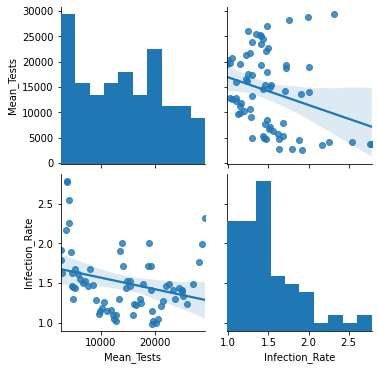

In [55]:
seaborn.pairplot(data3, vars=['Mean_Tests', 'Infection_Rate'], kind='reg')

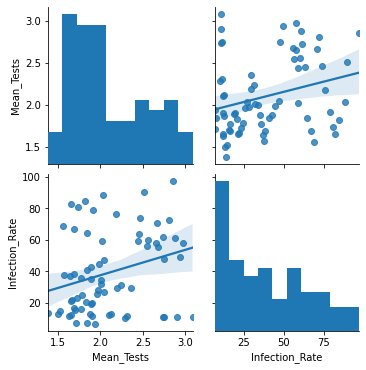

In [57]:
seaborn.pairplot(data4, vars=['Mean_Tests', 'Infection_Rate'], kind='reg')

In [215]:
X=list(dfr2['Williamson'])
Y=list(dft3['Williamson'])
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.t_test([1, 0]))
results.summary()

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0           4.72e+04   4581.744     10.302      0.000    3.81e+04    5.63e+04


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     16.93
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           6.52e-05
Time:                        21:32:11   Log-Likelihood:                -1651.1
No. Observations:                 145   AIC:                             3306.
Df Residuals:                     143   BIC:                             3312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.72e+04   4581.744     10.302      0.000    3.81e+04    5.63e+04
x1         -1.549e+04   3765.948     -4.114      0.000   -2.29e+04   -8050.717
==============================================================================
Omnibus:                       14.049   Durbin-Watson:                   0.032
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.850
Skew:                           0.397   Prob(JB):                       0.0197
Kurtosis:                       2.182   Cond. No.                         5.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""